# Programming Assignment 4

Celio Bueri, Christoph Stelz

## Exercise question

Consider the following visualization of the two training sets:

![](figures/exercise_question.svg)

It is easy to see that the first training data set can be separated with a line in the upper right corner, i.e. the set is linear separable.

In the second example, the data are not linearly separable. But because our Perceptron is a linear classifier with binary inputs and outputs, it is unable to fit to this scenario appropriately.

In this case, we would have to hand-engineer an additional feature for the classifier to be able to fit. For example, instead of the month we could consider a property like `is_summer` derived from the month and location on the northern or southern hemisphere.

## Boilerplate code

This is the base class for our linear classifiers.

In [1]:
import numpy as np
from sklearn.base import BaseEstimator

class LinearClassifier(BaseEstimator):
    """
    General class for binary linear classifiers. Implements the predict
    function, which is the same for all binary linear classifiers. There are
    also two utility functions.
    """

    def decision_function(self, X):
        """
        Computes the decision function for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """
        return X.dot(self.w)

    def predict(self, X):
        """
        Predicts the outputs for the inputs X. The inputs are assumed to be
        stored in a matrix, where each row contains the features for one
        instance.
        """

        # First compute the output scores
        scores = self.decision_function(X)

        # Select the positive or negative class label, depending on whether
        # the score was positive or negative.
        out = np.select([scores >= 0.0, scores < 0.0],
                        [self.positive_class,
                         self.negative_class])
        return out

    def find_classes(self, Y):
        """
        Finds the set of output classes in the output part Y of the training set.
        If there are exactly two classes, one of them is associated to positive
        classifier scores, the other one to negative scores. If the number of
        classes is not 2, an error is raised.
        """
        classes = sorted(set(Y))
        if len(classes) != 2:
            raise Exception("this does not seem to be a 2-class problem")
        self.positive_class = classes[1]
        self.negative_class = classes[0]

    def encode_outputs(self, Y):
        """
        A helper function that converts all outputs to +1 or -1.
        """
        return np.array([1 if y == self.positive_class else -1 for y in Y])

## SVC Implementation

Here we implement the SVC training algorithm found in the paper by Shalev-Shwartz et al.

Parts of the class are adapted from the Perceptron example.

In [2]:
class SVCImpl(LinearClassifier):
    def __init__(self, n_iter=1000, regularizer=0.001, print_iteration_loss=True):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many samples should be considered for training.
        If print_iteration_loss is set to False, no updates on the training
        process will be printed.
        """
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_iteration_loss = print_iteration_loss

    def fit(self, X, Y):
        """
        Train a linear classifier using the Pegasos learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

        # pick random indexes for each iteration
        indices = np.random.randint(X.shape[0], size=self.n_iter)

        # initialise the number of iteration
        t = 0

        for i in indices:
            t += 1
            # update the learning rate
            lr = 1.0 / (self.regularizer * t)

            x, y = X[i], Ye[i]

            # Compute the output score for this instance.
            score = x.dot(self.w)

            # update the weights
            if y * score < 1:
                self.w = (1 - self.regularizer * lr) * self.w + lr * y * x
            else:
                self.w = (1 - self.regularizer * lr) * self.w

            # print every 1000 iterations
            if self.print_iteration_loss and t % 1000 == 0:
                print(f'iteration : {t}, train_loss : { - self.score(X, Y)}')

    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return -(self.regularizer / 2 * min_weight + loss / X.shape[0])

## Logistic Regression Implementation

In [3]:
class LogisticRegressionImpl(LinearClassifier):
    def __init__(self, n_iter=1000, regularizer=0.001, print_iteration_loss=True):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_iteration_loss = print_iteration_loss

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, Y):
        """
        Train a linear classifier using the pegasos learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)

       # pick random indexes for each iteration
        indices = np.random.randint(X.shape[0], size=self.n_iter)

        # initialise the number of iteration
        t = 0

        for i in indices:
            t += 1
            # update the learning rate
            lr = 1.0 / (self.regularizer * t)

            x, y = X[i], Ye[i]

            # Compute the output score for this instance.
            score = x.dot(self.w)

            # update the weights
            if y * score < 1:
                self.w = (1 - self.regularizer * lr) * self.w + lr * x * y / (1 + np.exp(y*score))
            else:
                self.w = (1 - self.regularizer * lr) * self.w

            # print every 1000 iterations
            if self.print_iteration_loss and t % 1000 == 0:
                print(f'iteration : {t}, train_loss : { - self.score(X, Y)}')

    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for logistic regression
            loss += np.log(1 + np.exp(-y * x.dot(self.w)))
        return -(self.regularizer / 2 * min_weight + loss / X.shape[0])

## Preparing training data

Here we load our data from the textfile, use 80% of it for training and 20% for testing our classifiers.

In [4]:

import time

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


def read_data(corpus_file):
    X = []
    Y = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            _, y, _, x = line.split(maxsplit=3)
            X.append(x.strip())
            Y.append(y)
    return X, Y


# Read all the documents.
X, Y = read_data('data/all_sentiment_shuffled.txt')

# Split into training and test parts.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=0)


In [5]:
print(f"Our training dataset contains {len(Xtrain)} samples.")

Our training dataset contains 9531 samples.


## Testing our classifiers

We create a pipeline with a TfidfVectorizer and use only the 1000 best features. Then we train our SVC on $10\,000$ samples with a regularizer value of $0.0001$.

In [6]:

# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    SVCImpl(n_iter=10000, regularizer=0.0001)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

iteration : 1000, train_loss : 1.8570092042995647
iteration : 2000, train_loss : 1.0675309594121538
iteration : 3000, train_loss : 0.7837818830556673
iteration : 4000, train_loss : 0.6604807235583925
iteration : 5000, train_loss : 0.587847304163608
iteration : 6000, train_loss : 0.5375205023786316
iteration : 7000, train_loss : 0.5125643019352591
iteration : 8000, train_loss : 0.4920794052667724
iteration : 9000, train_loss : 0.5166901129363458
iteration : 10000, train_loss : 0.45465316763362496
Training time: 1.65 sec.
Accuracy: 0.8091.


In [7]:

# Set up the preprocessing steps and the classifier.
pipeline = make_pipeline(
    TfidfVectorizer(),
    SelectKBest(k=1000),
    Normalizer(),
    LogisticRegressionImpl(n_iter=10000, regularizer=0.0001)
)

# Train the classifier.
t0 = time.time()
pipeline.fit(Xtrain, Ytrain)
t1 = time.time()
print('Training time: {:.2f} sec.'.format(t1-t0))

# Evaluate on the test set.
Yguess = pipeline.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

iteration : 1000, train_loss : 1.3169432572978876
iteration : 2000, train_loss : 0.6322705321395731
iteration : 3000, train_loss : 0.5262734438194467
iteration : 4000, train_loss : 0.4870529222015718
iteration : 5000, train_loss : 0.452090813648628
iteration : 6000, train_loss : 0.4396097492638769
iteration : 7000, train_loss : 0.44485574482690793
iteration : 8000, train_loss : 0.4572865894544195
iteration : 9000, train_loss : 0.4360114935474195
iteration : 10000, train_loss : 0.430937980836665
Training time: 1.71 sec.
Accuracy: 0.8154.


As we can see, the SVC yields an accuracy of 82% and the logistic regression performs slightly worse with an accuracy of around 81%.

However, this is with guesstimated hyperparameters and leaves some accuracy on the table.

## Hyperparameter Optimization

We perform a grid search and optimize the following hyperparameters:

- iteration count set to ten thousand, three thousand, hundred thousand and one million
- regularizer set to $10^{-2}$, …, $10^{-5}$

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = {
    'classifier__n_iter': [10000, 30000, 100000, 1000000],
    'classifier__regularizer': [0.01, 0.001, 0.0001, 0.00001]
}

### SVC

In [9]:
pipeline = Pipeline(steps=[
    ("vect",TfidfVectorizer()),
    ("select", SelectKBest(k=1000)),
    ("norm", Normalizer()),
    ("classifier", SVCImpl(print_iteration_loss=False))
])

grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, return_train_score=True)

grid_search.fit(X, Y)

print("Best parameter (loss=%0.3f):" % grid_search.best_score_)
print(grid_search.best_params_)

Yguess = grid_search.best_estimator_.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

Best parameter (loss=-0.426):
{'classifier__n_iter': 1000000, 'classifier__regularizer': 1e-05}
Accuracy: 0.8871.


Properly tuning the hyperparameters resulted in a huge performance gain. The best estimator iterates over the training set around 100 times and uses a really small regularizer term.

This allows it to get an accuracy of around 88.5% on the test set!

### Logistic Regression

In [10]:
log_pipeline = Pipeline(steps=[
    ("vect",TfidfVectorizer()),
    ("select", SelectKBest(k=1000)),
    ("norm", Normalizer()),
    ("classifier", LogisticRegressionImpl(print_iteration_loss=False))
])

log_grid_search = GridSearchCV(log_pipeline, param_grid, n_jobs=-1, return_train_score=True)

log_grid_search.fit(X, Y)

print("Best parameter (loss=%0.3f):" % log_grid_search.best_score_)
print(log_grid_search.best_params_)

log_Yguess = log_grid_search.best_estimator_.predict(Xtest)
print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, log_Yguess)))

Best parameter (loss=-0.405):
{'classifier__n_iter': 1000000, 'classifier__regularizer': 1e-05}
Accuracy: 0.8808.


With the tuning, our logistic regression is almost at the same level of accuracy as the SVC. Interestingly, it chose the same hyper parameters. In future research, it might be interesting to train with more iterations and explore the regularizer value space more thoroughly.

## Optimizing Performance

### a) BLAS operations

In this version we replaced the Numpy operations with BLAS functions from scipy.
One pitfall we encountered is that with inplace operations like `daxpy`, the argument ordering matters a lot.

In [11]:
from scipy.linalg.blas import ddot, dscal, daxpy

class SVCImplBLAS(LinearClassifier):
    def __init__(self, n_iter=1000, regularizer=0.001, print_iteration_loss=True):
        """
        The constructor can optionally take a parameter n_iter specifying how
        many times we want to iterate through the training set.
        """
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_iteration_loss = print_iteration_loss

    def fit(self, X, Y):
        """
        Train a linear classifier using the pegasos learning algorithm.
        """

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        self.find_classes(Y)

        # Convert all outputs to +1 (for the positive class) or -1 (negative).
        Ye = self.encode_outputs(Y)

        # If necessary, convert the sparse matrix returned by a vectorizer
        # into a normal NumPy matrix.
        if not isinstance(X, np.ndarray):
            X = X.toarray()

        # Initialize the weight vector to all zeros.
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        
        t = 0
        # pick random indexes for each iteration
        indices = np.random.randint(X.shape[0], size=self.n_iter)

        # training algorithm:
        for i in indices:
            t += 1
            # update the learning rate
            lr = 1.0 / (self.regularizer * t)

            x, y = X[i], Ye[i]

            # Compute the output score for this instance.
            score = ddot(self.w, x)

            # since in either case we are going to scale the weight vector
            # by this term, we can pull it outside the if-clause
            dscal(1 - self.regularizer * lr, self.w)


            if y * score < 1:
                # in this case, we also need to add to the weight vector
                # note the order of the arguments: w += a * x
                daxpy(x, self.w, a=(lr * y))
                
            if self.print_iteration_loss and t % 1000 == 0:
                print(f'iteration {i}, train_loss : {self.score(X, Y)}')

    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(ddot(self.w, self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * ddot(x, self.w))
        return self.regularizer / 2 * min_weight + loss / X.shape[0]

### b) Sparse Vectors

Here we only store values that are non-zero. We do this by keeping track of their inidices.

In [12]:

class SVCImplSparse(LinearClassifier):

    def __init__(self, n_iter=1000, regularizer=0.001, print_iteration_loss=True):
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_iteration_loss = print_iteration_loss

    def fit(self, X, Y):
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.

        indices = np.random.randint(1,X.shape[0], size=self.n_iter)

        # zip entries together and cache them to speed up the iteration
        XY = list(zip(X[indices], Ye[indices]))

        t = 0
        for i in range(self.n_iter):
            t += 1

            lr = 1.0 / (self.regularizer * t)

            # deconstruct the training sample
            x, y = XY[i]

            # Compute the output score for this instance.
            score = np.dot(self.w[x.indices], x.data)

            # regularizer
            self.w *= (1 - self.regularizer * lr)
            
            # If there was an error, update the weights.
            if y*score <= 0:
                self.w[x.indices] += (lr * y) * x.data

            if self.print_iteration_loss and t % 1000 == 0:
                print(f'iteration : {t}, train_loss : { - self.score(X, Y)}')


    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return -(self.regularizer / 2.0 * min_weight + loss / X.shape[0])

### c) Faster scaling

In addition to the sparse version, we extract a scaling factor that can be updated faster than a whole vector. The scaling factor is then multiplied into the vector at the very end.

In [13]:
def add_sparse_to_dense(x, w, factor):
    """
    Adds a sparse vector x, scaled by some factor, to a dense vector.
    This can be seen as the equivalent of w += factor * x when x is a dense
    vector.
    """
    w[x.indices] += factor * x.data

def sparse_dense_dot(x, w, a):
    """
    Computes the dot product between a sparse vector x and a dense vector w.
    """
    return a * np.dot(w[x.indices], x.data)


class SVCImplSparseScaling(LinearClassifier):

    def __init__(self, n_iter=1000, regularizer=0.001, print_iteration_loss=True):
        self.n_iter = n_iter
        self.regularizer = regularizer
        self.print_iteration_loss = print_iteration_loss

    def fit(self, X, Y):
        self.find_classes(Y)

        # First determine which output class will be associated with positive
        # and negative scores, respectively.
        Ye = self.encode_outputs(Y)

        # Initialize the weight vector to all zeros.
        self.w = np.zeros(X.shape[1])

        # Iteration through sparse matrices can be a bit slow, so we first
        # prepare this list to speed up iteration.

        # pick indices randomly
        indices = np.random.randint(1,X.shape[0], size=self.n_iter)

        # list of instances picked randomly
        XY = list(zip(X[indices], Ye[indices]))

        # initialize vector scaling
        a = 1
        #  number of iterations
        t = 0
        for i in range(self.n_iter):
            t += 1
            # update learning rate
            lr = 1.0 / (self.regularizer * t)

            x, y = XY[i]

            # Compute the output score for this instance.
            score = sparse_dense_dot(x, self.w, a)

            # If there was an error, update the weights.
            if y*score <= 0:
                add_sparse_to_dense(x, self.w, (lr * y / a))

            # update vector scaling
            # We verify that a is positive because for large number of iteration
            # a could be rounded as 0.0 and cause an error
            if (1 - self.regularizer * lr) * a > 0.0:
                a = (1 - self.regularizer * lr) * a

        self.w =  a * self.w


    def score(self, X, Y):
        loss = 0.0
        min_weight = np.min(self.w.dot(self.w))
        for x, y in zip(X, self.encode_outputs(Y)):
            # loss for svc
            loss += max(0.0, 1.0 - y * x.dot(self.w))
        return -(self.regularizer / 2 * min_weight + loss / X.shape[0])

### Performance Evaluation

We no evaluate the performance of our different estimators.
We do this by creating a fitting the pipeline a number of times. Also, we keep track of the accuracy to check that we still get correct results.

In [14]:
def evaluate_pipeline(pipeline):
    #pipeline.fit(Xtrain, Ytrain) # make sure its fitted
    Yguess = pipeline.predict(Xtest)
    print('Accuracy: {:.4f}.'.format(accuracy_score(Ytest, Yguess)))

#### Baseline

First we evaluate our baseline version, which is our initial implementation from above.

In [15]:
def create_baseline_classifier():
    np.random.seed(42)
    pipeline_baseline = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k=1000),
        Normalizer(),
        SVCImpl(n_iter=100000,regularizer=0.0001,print_iteration_loss=False)
    )
    pipeline_baseline.fit(Xtrain, Ytrain)
    return pipeline_baseline

In [16]:
%%timeit
_ = create_baseline_classifier()

1.96 s ± 113 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
evaluate_pipeline(create_baseline_classifier())

Accuracy: 0.8368.


#### BLAS

Next comes the BLAS version.

In [18]:
def create_blas_classifier():
    np.random.seed(42) # fix the seed so the two algorithms see the same samples
    pipeline_blas = make_pipeline(
        TfidfVectorizer(),
        SelectKBest(k=1000),
        Normalizer(),
        SVCImplBLAS(n_iter=100000,regularizer=0.0001,print_iteration_loss=False)
    )
    pipeline_blas.fit(Xtrain, Ytrain)
    return pipeline_blas

In [19]:
%%timeit
_ = create_blas_classifier()

1.8 s ± 79.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
evaluate_pipeline(create_blas_classifier())

Accuracy: 0.8368.


As we can see, the BLAS optimization yields us faster training times at no expense to the accuracy. The standard deviation on the benchmark runs seems to indicate that the difference is statistically significant.

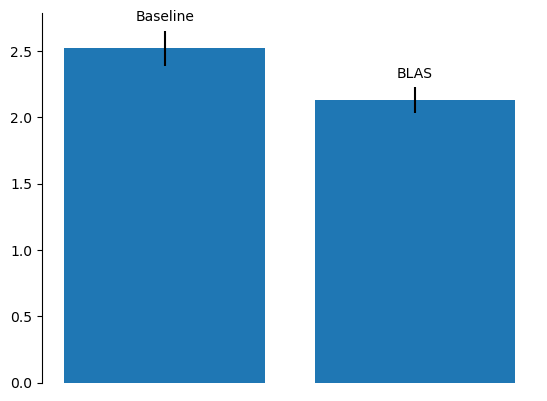

In [21]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
b = ax.bar([1,2], [1.96, 1.8], yerr=[113e-3, 79.9e-3], width=0.8)
ax.bar_label(b, labels=['Baseline', 'BLAS'], padding=5)
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.get_xaxis().set_visible(False)

#### Sparse vector

Now we will try our sparse vector variant.
Note that in the pipeline below, we omit the `SelectKBest` step and train on all features. This makes a performance comparison to the baseline version unreasonable.

Furthermore, we increased the `ngram_range` to $[1,2]$, meaning that the feature space explodes even further. When we try to ran this with our baseline version, we got an out-of-memory exception because the weight matrix would exceed our main memory size.

In [22]:
def make_sparse_classifier():
    np.random.seed(42)
    pipeline_sparse = make_pipeline(
        TfidfVectorizer(ngram_range=(1,2)),
        Normalizer(),
        SVCImplSparse(n_iter=100000,regularizer=0.0001,print_iteration_loss=False)
    )
    pipeline_sparse.fit(Xtrain, Ytrain)
    return pipeline_sparse

In [31]:
%%timeit -n1 -r1
_ = make_sparse_classifier()

38 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [32]:
evaluate_pipeline(make_sparse_classifier())

Accuracy: 0.8519.


With the increased feature count, we exceed 85% accuracy! That's nice. However, the operation is a bit slow.

#### Speeding up the scaling operation

Finally, we run the optimization of the scaling factor with identical parameters to the above sparse version.

In [33]:
def make_scaling_classifier():
    np.random.seed(42)
    pipeline_sparse_scaling = make_pipeline(
        TfidfVectorizer(ngram_range=(1,2)),
        Normalizer(),
        SVCImplSparseScaling(n_iter=100000,regularizer=0.0001,print_iteration_loss=False)
    )
    pipeline_sparse_scaling.fit(Xtrain, Ytrain)
    return pipeline_sparse_scaling

In [34]:
%%timeit -n 1 -r 1
_ = make_scaling_classifier()

8.72 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [35]:
evaluate_pipeline(make_scaling_classifier())

Accuracy: 0.8561.


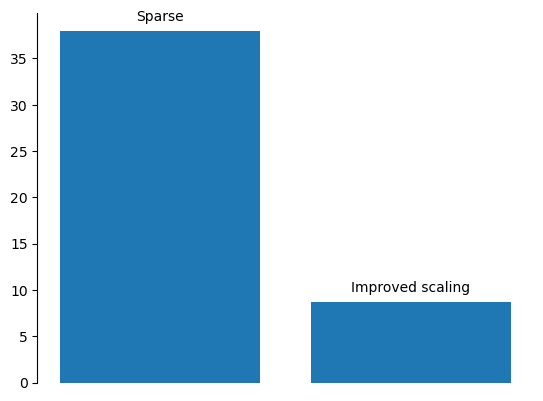

In [37]:
import matplotlib.pyplot as plt

f, ax = plt.subplots()
b = ax.bar([1,2], [38, 8.72], width=0.8)
ax.bar_label(b, labels=['Sparse', 'Improved scaling'], padding=5)
ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.get_xaxis().set_visible(False)

As we can see, the scaling mechanism wildly improves our training performance without lowering the accuracy!